In [1]:
!sudo apt-get update
!sudo apt-get install -y build-essential python3-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,626 B in 3s (1,201 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide i

In [2]:
!pip install pystan==2.19.1.1

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


In [3]:
!pip install prophet

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import joblib

In [5]:
customers = pd.read_csv('customers.csv')
order_items = pd.read_csv('order_items.csv')
order_payments = pd.read_csv('order_payments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
reviews = pd.read_csv('reviews.csv')
sellers = pd.read_csv('sellers.csv')

In [6]:
merged_data = pd.merge(orders, order_items, on='order_id')
merged_data = pd.merge(merged_data, order_payments, on='order_id')
merged_data['purchase_timestamp'] = pd.to_datetime(merged_data['purchase_timestamp'])

In [7]:
# Corregir las fechas incorrectas
merged_data.loc[merged_data['purchase_timestamp'].dt.year == 2222, 'purchase_timestamp'] = merged_data['purchase_timestamp'].apply(
    lambda x: x.replace(year=2022) if x.year == 2222 else x
)

# Filtrar fechas inusuales (por ejemplo, fuera de un rango razonable)
merged_data = merged_data[(merged_data['purchase_timestamp'] >= '2010-01-01') & (merged_data['purchase_timestamp'] <= pd.Timestamp.today())]

In [8]:
merged_data['order_date'] = merged_data['purchase_timestamp'].dt.date
demand_data = merged_data.groupby('order_date').size().reset_index(name='order_count')

# Preparar los datos para Prophet
demand_data.rename(columns={'order_date': 'ds', 'order_count': 'y'}, inplace=True)

print(demand_data.head())

           ds   y
0  2021-09-04   2
1  2021-09-05   1
2  2021-10-02   1
3  2021-10-03   8
4  2021-10-04  76


In [9]:
# Definir y entrenar el modelo
model = Prophet(daily_seasonality=True)
model.fit(demand_data)

# Calcular la fecha más reciente de los datos
most_recent_date = demand_data['ds'].max()

# Parámetro n (número de días para predecir)
n = 30


# Realizar una predicción para los próximos n días después de la fecha más reciente
future = model.make_future_dataframe(periods=n)
future = future[future['ds'] > pd.to_datetime(most_recent_date)]  # Filtrar solo las fechas futuras
forecast = model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpawl8d5sb/0ptm8rut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpawl8d5sb/381w84b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35564', 'data', 'file=/tmp/tmpawl8d5sb/0ptm8rut.json', 'init=/tmp/tmpawl8d5sb/381w84b8.json', 'output', 'file=/tmp/tmpawl8d5sb/prophet_model4t7cnmxw/prophet_model-20240730171012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [10]:
# Mostrar la predicción
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(n))

           ds        yhat  yhat_lower  yhat_upper
0  2023-09-04  261.001662  165.792032  353.180253
1  2023-09-05  252.434856  161.236642  342.592507
2  2023-09-06  244.905044  151.702109  340.777663
3  2023-09-07  234.285386  143.398532  330.814903
4  2023-09-08  187.909346   88.786578  280.463991
5  2023-09-09  202.134303  108.673679  297.862669
6  2023-09-10  257.030708  165.071242  351.720819
7  2023-09-11  259.247232  157.664769  356.329756
8  2023-09-12  250.680426  152.562564  341.178760
9  2023-09-13  243.150615  144.250538  337.712242
10 2023-09-14  232.530956  129.147763  331.758269
11 2023-09-15  186.154916   84.766071  282.029620
12 2023-09-16  200.379874  105.775377  287.916387
13 2023-09-17  255.276278  154.797823  348.390863
14 2023-09-18  257.492803  156.625897  341.876632
15 2023-09-19  248.925997  141.356704  340.555013
16 2023-09-20  241.396186  140.368247  329.679172
17 2023-09-21  230.776527  137.085320  324.748515
18 2023-09-22  184.400487   84.859861  283.842741


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


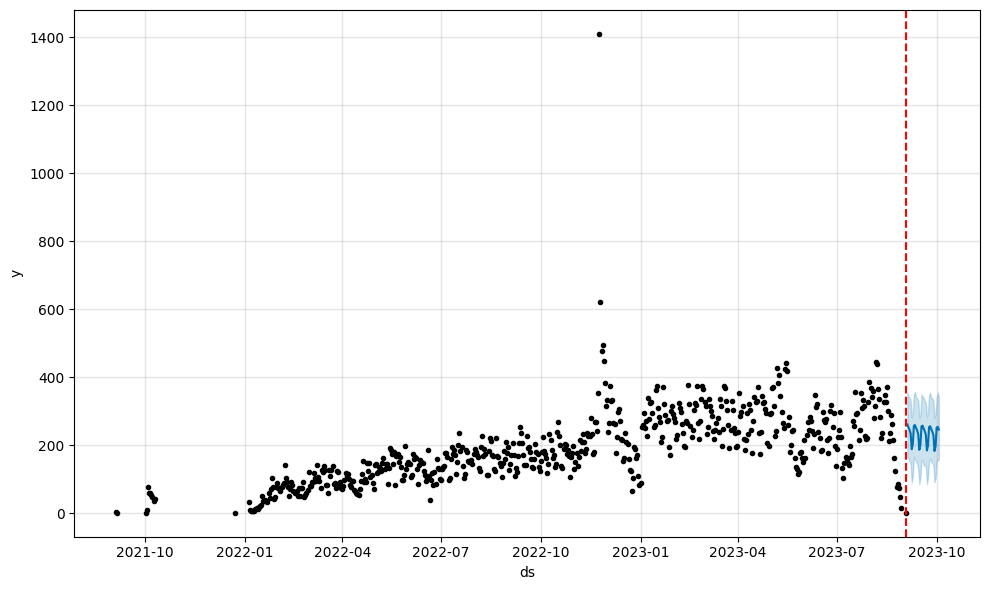

In [11]:
# Graficar las predicciones
fig = model.plot(forecast)
plt.axvline(x=most_recent_date, color='r', linestyle='--')
plt.show()

In [12]:
model_filename = 'prophet_model.pkl'
joblib.dump(model, model_filename)

['prophet_model.pkl']